In [52]:
# CELL 1: Imports for whole notebook
# File system manangement
import os

#Garbage Collector
import gc

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import s3fs

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
#import seaborn as sns    #NOTE: Will have to install seaborn later
%matplotlib inline
import matplotlib.pyplot as plt

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb # LightGBM Classifier


import matplotlib.pyplot as plt

#To read in files
fs = s3fs.S3FileSystem(anon=False)

#The name of the S3 bucket that contains the files
#Download the data from the kaggle link in the README
bucket='group12credits'

    


In [53]:
# Cell 2: Function to aggregate numerical data correspoding grouped by 'group_var'

#Function aggregates the numeric values in df.
# Used to create features for each instance of the grouping variable

#Input(s):
    #df -> a dataframe
    #group_var (string)->the variable by which to group df
    #df_name (string)-> the variable used to rename the columns

#Output(s):
    #agg(dataframe)- >a dataframe with the statistics aggregated for  all numeric columns.
     #Each instance of the grouping variable will have the statistics (mean, min, max, sum; currently supported) calculated.
    #The columns are also renamed to keep track of features created.

def agg_numeric(df, group_var, df_name):

    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [54]:
# CELL 3: Count d  counts for categorial variable in groupvar

def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical



In [55]:
# Cell 4: Calculates counts of missing values

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
                
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [56]:
# Cell 5: load files
fs = s3fs.S3FileSystem(anon=False)

with fs.open('data-science-group12/application_train.csv') as f:
    train = pd.read_csv(f)
    
with fs.open('data-science-group12/bureau.csv') as f:
    bureau = pd.read_csv(f)
    
with fs.open('data-science-group12/bureau_balance.csv') as f:
    bureau_balance = pd.read_csv(f)
    
with fs.open('data-science-group12/POS_CASH_balance.csv') as f:
    POS_CASH_balance = pd.read_csv(f)

In [57]:
# 6) Run four below, get aggregations and categorical counts for bureau and bureau_balance
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

In [58]:
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [59]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')

In [60]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

In [61]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

In [62]:
# Cell 7) Creates data frame of loans stats for each client

# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [63]:
# CELL 8) Aggregate stats for each client in POS_CASH

valid_IDs=train['SK_ID_CURR'].copy()
filteredPos = POS_CASH_balance.loc[POS_CASH_balance['SK_ID_CURR'].isin(valid_IDs)].sort_values(by=['SK_ID_CURR'])
POS_agg = agg_numeric(filteredPos, group_var = 'SK_ID_CURR', df_name = 'POS_CASH')

In [64]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [65]:
# CELL 9) merge new dataframes with train

train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

train = train.merge(POS_agg, on='SK_ID_CURR', how = 'left')

In [66]:
# CELL 10) List missing values over 90%

missing_train = missing_values_table(train)
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])

In [67]:
# CELL 11) Read in test data, merge same bureau data

# Read in the test dataframe
with fs.open('data-science-group12/application_test.csv') as f:
    test = pd.read_csv(f)
# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

# Merge with POS_cash
test = test.merge(POS_agg, on='SK_ID_CURR', how = 'left')


In [68]:
# CELL 12) Load the training data and their labels into a dataframe

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [69]:
# CELL 13) Missing over 90% in test

missing_test = missing_values_table(test)
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])

In [70]:
# CELL 14) Drop columns with too much missing data

missing_columns = list(set(missing_test_vars + missing_train_vars))
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [71]:
# CELL 15) Calculate correlations

#Takes a while to run
corrs = train.corr()

In [72]:
# CELL 16) Get variables above threshold

corrs = corrs.sort_values('TARGET', ascending = False)

In [73]:
# CELL 17) Get columns to remove, too colinear

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [74]:
# CELL 18) Remove columns calculated above

# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  129


In [75]:
# CELL 19) Imports needed to model, classify, and compute metrics

train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 204)
Testing Corrs Removed Shape:  (48744, 203)


In [86]:
# CELL 20) Encode, align and covert to numpy

train_lgbm = train.copy()

# Training labels
labels = train_lgbm['TARGET']

# Drops IDs and Targets
train_lgbm = train_lgbm.drop(columns = ['SK_ID_CURR', 'TARGET'])

# One Hot Encoding
train_lgbm = pd.get_dummies(train_lgbm)

# Convert to numpy array for use in the classifier.
train_lgbm = np.array(train_lgbm)

# Empty array for out of fold validation predictions
train_preds = np.zeros(train_lgbm.shape[0])

In [94]:
# CELL 22) Creates models, trains and calculates respective ROCS

%%time
# Do 3 folds.
n_folds = 3
# No shuffling to ensure we hit all data points.
k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(train_lgbm):
    
    # Training data for the fold
    train_features, train_labels = train_lgbm[train_indices], labels[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train_lgbm[valid_indices], labels[valid_indices]
    
    
    # Create the model
    model = lgb.LGBMClassifier(n_estimators=10000, boosting_type='goss', objective = 'binary', 
                               class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, 
                               subsample = 0.8, n_jobs = -1, random_state = 50)

    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'], categorical_feature = 'auto',
              early_stopping_rounds = 100, verbose = 200)
    
    # Record the out of fold predictions, this is what we will use for ROC/Accuracy 
    train_preds[valid_indices] = model.predict_proba(valid_features)[:, 1]
    
    # Clean up memory
    gc.enable()
    del model, train_features, valid_features
    gc.collect()

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.817998	train's binary_logloss: 0.529526	valid's auc: 0.765957	valid's binary_logloss: 0.550777
[400]	train's auc: 0.857099	train's binary_logloss: 0.488249	valid's auc: 0.76637	valid's binary_logloss: 0.524759
Early stopping, best iteration is:
[339]	train's auc: 0.846399	train's binary_logloss: 0.499806	valid's auc: 0.766829	valid's binary_logloss: 0.53197
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.818628	train's binary_logloss: 0.529125	valid's auc: 0.762505	valid's binary_logloss: 0.55177
Early stopping, best iteration is:
[258]	train's auc: 0.831236	train's binary_logloss: 0.515898	valid's auc: 0.762879	valid's binary_logloss: 0.543533
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.816638	train's binary_logloss: 0.531252	valid's auc: 0.76721	valid's binary_logloss: 0.550181
Early stopping, best iteration is:
[235]	train's auc

In [96]:
# CELL 23) Creates models, trains and calculates respective ROCS

#ROC AUC Curve 
from sklearn.metrics import roc_auc_score, roc_curve, auc 

#Calculate AUC:
print ('ROC AUC Score on the train dataset', roc_auc_score(labels, train_preds))


ROC AUC Score on the train dataset 0.7657254584543998


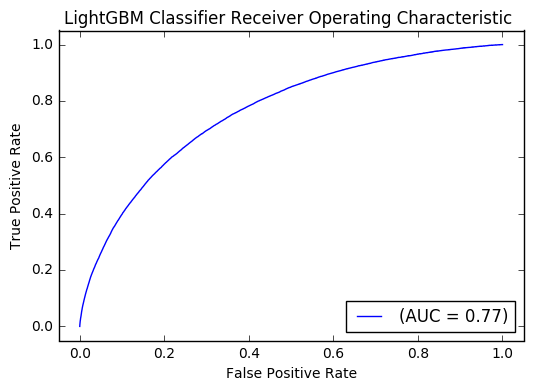

In [97]:
# CELL 24) Graphs ROC

fpr,tpr, thresholds= roc_curve(labels, train_preds) 
roc_auc=auc(fpr,tpr)


#Visual :https://www.kaggle.com/jomaxx/area-under-the-roc-curve-explained 
#fig, axs = plt.subplots(1, 2, figsize = (16,8))

#Plot ROC 
plt.plot(fpr, tpr, lw=1, label='(AUC = %0.2f)' % (roc_auc))

plt.title('LightGBM Classifier Receiver Operating Characteristic ')
plt.legend(loc="lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
predictions = [round(value) for value in train_preds]
# evaluate predictions with accuracy as well
accuracy = accuracy_score(labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))